In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=False
)

100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, pooling="max"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        if pooling == "max":
            self.pool = nn.MaxPool2d(2)
        elif pooling == "avg":
            self.pool = nn.AvgPool2d(2)
        else:
            raise ValueError("pooling must be 'max' or 'avg'")

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

In [4]:
model_max = SimpleCNN(pooling="max").to(device)
model_avg = SimpleCNN(pooling="avg").to(device)

model_max.eval()
model_avg.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [5]:
def collect_feature_variance(model, loader, num_batches=5):
    variances = []

    with torch.no_grad():
        for i, (x, _) in enumerate(loader):
            if i >= num_batches:
                break

            x = x.to(device)
            feats = model(x)  # [B, C, H, W]

            # Flatten spatial dimensions
            feats = feats.view(feats.size(0), feats.size(1), -1)

            # Variance across spatial dimensions
            var = feats.var(dim=2).mean().item()
            variances.append(var)

    return np.mean(variances)

In [6]:
var_max = collect_feature_variance(model_max, loader)
var_avg = collect_feature_variance(model_avg, loader)

print("Feature variance with Max Pooling:", var_max)
print("Feature variance with Avg Pooling:", var_avg)

Feature variance with Max Pooling: 0.00607155142351985
Feature variance with Avg Pooling: 0.0011487514711916447


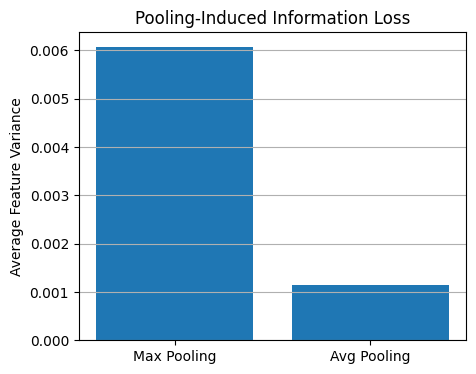

In [7]:
plt.figure(figsize=(5,4))
plt.bar(["Max Pooling", "Avg Pooling"], [var_max, var_avg])

plt.ylabel("Average Feature Variance")
plt.title("Pooling-Induced Information Loss")
plt.grid(axis="y")
plt.show()

### Outcome:

### Observations and Interpretation

### Observations and Interpretation

Max pooling produces substantially higher feature variance than average pooling across spatial dimensions. This indicates that max pooling preserves stronger, more selective activations, while average pooling aggressively smooths feature responses.

The lower variance observed with average pooling suggests increased information compression, consistent with its averaging behavior. In contrast, max pooling retains high-magnitude local responses, leading to richer but potentially less invariant representations.

These results highlight a fundamental trade-off introduced by pooling operations: max pooling favors discriminative feature preservation, whereas average pooling promotes invariance through smoothing, at the cost of representational detail.